Inference for an arbitrary image that is not part of the CamVid dataset.

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.optimizers import RMSprop
from camvid_dataset import dataset, load_camvid_tfrecords
from keras_fc_densenet import build_FC_DenseNet56, build_FC_DenseNet67, build_FC_DenseNet103
from camvid_utils import load_label_colors, color_label
from camvid_utils import normalize_image, unnormalize_image, show_image_row

In [4]:
label_colors_path = './camvid/label_colors.txt'
label_colors, _, _ = load_label_colors(label_colors_path)

In [5]:
# WATCH OUT: `Image.resize()` uses (width, height) to specify image size,
# everywhere else its specified the other way round!
image_size = (480, 384) 

image1 = np.array(Image.open('../street_pics/Turl_Street_Oxford.jpg')
                  .resize(image_size, Image.NEAREST))
image2 = np.array(Image.open('../street_pics/22.jpg')
                  .resize(image_size, Image.NEAREST))

images = np.vstack([np.expand_dims(image1, axis=0), 
                    np.expand_dims(image2, axis=0)])
images = normalize_image(images)
np_input_fn = tf.estimator.inputs.numpy_input_fn(images, y=None, batch_size=1,
                                              num_epochs=1, shuffle=False)

In [6]:
tf.reset_default_graph()

model_dir = '/tmp/retrained_model'

fc_dn_model = build_FC_DenseNet103(nb_classes=32, final_softmax=True, input_shape=(384, 480, 3))
fc_dn_model.compile(optimizer=RMSprop(lr=1e-4), 
                    loss='sparse_categorical_crossentropy')

estimator = tf.keras.estimator.model_to_estimator(keras_model=fc_dn_model, 
                                                      model_dir=model_dir)

INFO:tensorflow:Layers in each dense block: [4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4]
INFO:tensorflow:Number of skip connections: 5
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/retrained_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x181fe56e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
predictions = estimator.predict(input_fn=np_input_fn)
predicted_labels = [np.argmax(pred['softmax'], axis=-1) for pred in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/retrained_model/model.ckpt-37120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


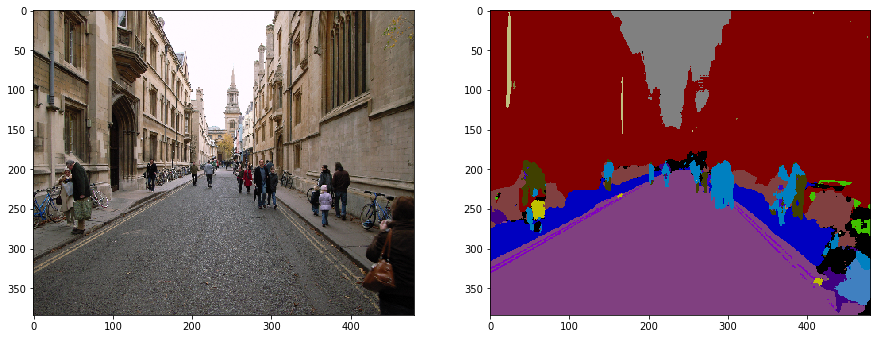

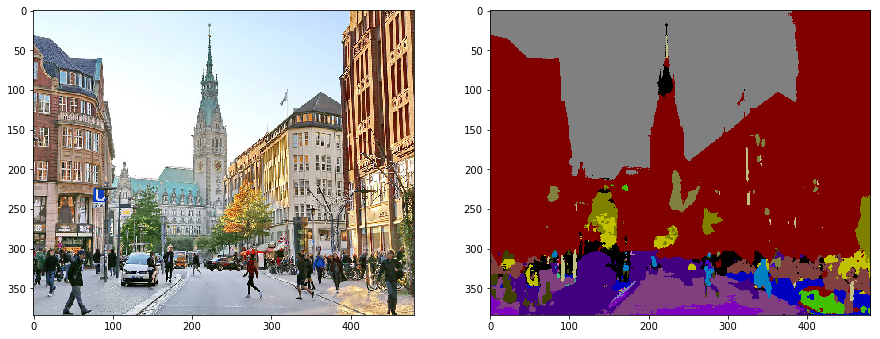

In [8]:
for i in range(len(predicted_labels)):
    image = unnormalize_image(images[i])    
    y_pred = predicted_labels[i].reshape((image.shape[0],image.shape[1]))
    y_pred = color_label(y_pred, label_colors)
    show_image_row([image, y_pred])
    plt.show()

It is interesting to see that even though the model achieves an accuray of 0.94 on the CamVid test dataset the perfomance on random pictures seems to be not that good. It detects the overall outlines but the details are messy. The model probably needs more training data. 

Also the images from the CamVid dataset are frames from video sequences. This means it contains lots of very similar images that end up in the train and test buckets. I wounder whether this creates some kind of target leak.